In [1]:
import yaml
from pathlib import Path

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

config['databricks']['catalog'], config['databricks']['schema'], config["databricks"]["volume"]

('portfolio_catalog', 'databricks_pipeline', 'data')

In [2]:
def running_on_databricks():
    """Detect if running in Databricks environment"""
    try:
        import pyspark.dbutils  # only available in Databricks
        return True
    except ImportError:
        return False

IS_DATABRICKS = running_on_databricks()
print(IS_DATABRICKS)

False


In [3]:
from pyspark.sql import functions as F
# from helper import run_forecast, aggregate_to_granularity, build_features, train_test_split

from helper import (
    aggregate_to_granularity, assert_unique_series_rows, build_features,
    train_test_split, model_factory, assemble_global_pipeline, fit_global_model, predict_global,
    compute_metrics, fit_predict_local, rolling_backtest, run_forecast, plot_forecast, plot_train_test_forecast)

from pyspark.sql import SparkSession

# Give Spark way more memory since you have 32GB RAM available
spark = SparkSession.builder \
    .appName("TimeSeriesForecast") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "16") \
    .config("spark.default.parallelism", "8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/27 01:18:14 WARN Utils: Your hostname, daniels-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.88.147 instead (on interface en13)
25/12/27 01:18:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/27 01:18:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load data (must include columns: date, sales, family, store_nbr)
if IS_DATABRICKS:
    df_raw = spark.read.format("delta").table('portfolio_catalog.databricks_pipeline.silver_training')

else:
    df_raw = (   
        spark.read.parquet('../notebooks/data/train.parquet')

        .withColumn("date", F.to_date(F.col("date"))))

df_raw.select(F.min("sales").alias("lowest_sales")).show()

# df_raw = df_raw.withColumn(
#     "sales",
#     F.when(F.col("sales") > 0, F.log(F.col("sales")))
#      .otherwise(F.lit(0))
# )

+------------+
|lowest_sales|
+------------+
|         0.0|
+------------+



In [15]:
from pyspark.sql.functions import year, sum as spark_sum

yearly_sales = (
    df_raw
    .withColumn("year", year("date"))
    .groupBy("family", "year")
    .agg(spark_sum("sales").alias("year_sales"))
)

pivot_sales = (
    yearly_sales
    .groupBy("family")
    .pivot("year")
    .agg(spark_sum("year_sales"))
)

pivot_sales = pivot_sales.orderBy("2017", ascending=False).show(35)

+--------------------+------------------+--------------------+--------------------+-------------------+--------------------+
|              family|              2013|                2014|                2015|               2016|                2017|
+--------------------+------------------+--------------------+--------------------+-------------------+--------------------+
|           GROCERY I|       5.8339929E7|6.5666790757999875E7| 7.622853900400001E7|8.608653896599971E7| 5.714093715800011E7|
|           BEVERAGES|        2.177788E7|         4.1050432E7|         4.8425895E7|        6.1747687E7|         4.3952592E7|
|             PRODUCE|           72805.0|2.3512527790476024E7|2.5595844556458004E7|4.424810044315998E7|2.9275406886366013E7|
|            CLEANING|       1.7514515E7|           1.94976E7|         2.2381431E7|        2.2628927E7|         1.5498816E7|
|               DAIRY|         7738893.0|         1.3491785E7|         1.4834138E7|        1.6967193E7|           1.14557E7|


In [ ]:
from pyspark.sql.functions import col, min

late_start_df = (
    df
    .filter(col("y") > 0)
    .groupBy("family")
    .agg(min("date").alias("late_start_date"))
)


In [5]:
df_raw.select("family").distinct().show(truncate=False)

+-----------------------+
|family                 |
+-----------------------+
|HOME APPLIANCES        |
|POULTRY                |
|PREPARED FOODS         |
|GROCERY I              |
|BREAD/BAKERY           |
|MAGAZINES              |
|DELI                   |
|LINGERIE               |
|HOME CARE              |
|SEAFOOD                |
|LADIESWEAR             |
|BEAUTY                 |
|HOME AND KITCHEN II    |
|LIQUOR,WINE,BEER       |
|HARDWARE               |
|LAWN AND GARDEN        |
|PLAYERS AND ELECTRONICS|
|BOOKS                  |
|CLEANING               |
|HOME AND KITCHEN I     |
+-----------------------+
only showing top 20 rows


In [43]:
# df_raw = df_raw.filter(F.col("family") == "BOOKS")

In [44]:

cfg = {
    "data": {"date_col": "date", "target_col": "sales", "group_cols": ["family", 'store_nbr'],
             "freq": "D", "min_train_periods": 56},
    "aggregation": {"target_agg": "sum", "extra_numeric_aggs": {"dcoilwtico": "mean", "onpromotion": "sum"}},
    "features": {"lags": [1,7,14,28], "mas": [7,28], "add_time_signals": True},
    "split": {"mode": "horizon", "train_end_date": "", "test_horizon": 28},
    "model": {"type": "spark_gbt", "params": {"maxDepth": 7, "maxIter": 120}},
    # "model": {"type": "spark_lgbt", "params": {"maxDepth": 7, "maxIter": 120}},
    "evaluation": {"mase_seasonality": 7, "backtest": {"enabled": True, "folds": 4, "fold_horizon": 14, "step": 14}}
}

# --- Step 1: Features ---
df_feat = build_features(df_raw, cfg["data"]["date_col"], cfg["data"]["target_col"],
                         cfg["data"]["group_cols"], cfg["features"]["lags"], cfg["features"]["mas"],
                         cfg["features"]["add_time_signals"], pre_aggregate=True,
                         target_agg=cfg["aggregation"]["target_agg"],
                         extra_numeric_aggs=cfg["aggregation"].get("extra_numeric_aggs"))
df_feat.show(2)
display(df_feat.limit(5))

# --- Step 2: Split ---
train, test = train_test_split(df_feat, cfg["data"]["date_col"], cfg["data"]["group_cols"],
                               cfg["split"]["mode"], cfg["split"]["train_end_date"], cfg["split"]["test_horizon"],
                               cfg["data"]["min_train_periods"])

train.show(2)
test.show(2)


+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+-----+---+---+----------+-----+----+
|    family|store_nbr|      date|sales|dcoilwtico|onpromotion|lag_1|lag_7|lag_14|lag_28|              ma_7|ma_28|dow|dom|weekofyear|month|year|
+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+-----+---+---+----------+-----+----+
|AUTOMOTIVE|       10|2013-01-29|  1.0|     97.62|          0|  1.0|  1.0|   0.0|   0.0|1.1428571428571428| 1.75|  3| 29|         5|    1|2013|
|AUTOMOTIVE|       10|2013-01-30|  3.0|     97.98|          0|  1.0|  2.0|   6.0|   3.0|1.2857142857142858| 1.75|  4| 30|         5|    1|2013|
+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+-----+---+---+----------+-----+----+
only showing top 2 rows


DataFrame[family: string, store_nbr: int, date: date, sales: double, dcoilwtico: double, onpromotion: bigint, lag_1: double, lag_7: double, lag_14: double, lag_28: double, ma_7: double, ma_28: double, dow: int, dom: int, weekofyear: int, month: int, year: int]

+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+-----+---+---+----------+-----+----+
|    family|store_nbr|      date|sales|dcoilwtico|onpromotion|lag_1|lag_7|lag_14|lag_28|              ma_7|ma_28|dow|dom|weekofyear|month|year|
+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+-----+---+---+----------+-----+----+
|AUTOMOTIVE|       10|2013-01-29|  1.0|     97.62|          0|  1.0|  1.0|   0.0|   0.0|1.1428571428571428| 1.75|  3| 29|         5|    1|2013|
|AUTOMOTIVE|       10|2013-01-30|  3.0|     97.98|          0|  1.0|  2.0|   6.0|   3.0|1.2857142857142858| 1.75|  4| 30|         5|    1|2013|
+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+-----+---+---+----------+-----+----+
only showing top 2 rows


+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+------------------+---+---+----------+-----+----+
|    family|store_nbr|      date|sales|dcoilwtico|onpromotion|lag_1|lag_7|lag_14|lag_28|              ma_7|             ma_28|dow|dom|weekofyear|month|year|
+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+------------------+---+---+----------+-----+----+
|AUTOMOTIVE|       10|2017-07-19|  0.0|      47.1|          0|  0.0|  0.0|   2.0|   1.0|0.8571428571428571|1.6428571428571428|  4| 19|        29|    7|2017|
|AUTOMOTIVE|       10|2017-07-20|  1.0|     46.73|          0|  0.0|  3.0|   4.0|   3.0|0.5714285714285714|1.5714285714285714|  5| 20|        29|    7|2017|
+----------+---------+----------+-----+----------+-----------+-----+-----+------+------+------------------+------------------+---+---+----------+-----+----+
only showing top 2 rows


In [45]:

# --- Step 3: Train (global model) ---
est = model_factory(cfg["model"]["type"], cfg["model"]["params"])
feature_cols = [c for c in train.columns if c not in cfg["data"]["group_cols"] + [cfg["data"]["date_col"], cfg["data"]["target_col"], "label"]]
model = fit_global_model(train, cfg["data"]["target_col"], cfg["data"]["group_cols"], feature_cols, est)

# --- Step 4: Predict ---
pred = predict_global(model, test, cfg["data"]["group_cols"], cfg["data"]["date_col"], cfg["data"]["target_col"])
display(pred.limit(10))

# --- Step 5: Metrics ---
by_series, portfolio = compute_metrics(pred, cfg["data"]["date_col"], "y", "prediction",
                                       cfg["data"]["group_cols"], cfg["evaluation"]["mase_seasonality"])
display(by_series.orderBy("wMAPE")); display(portfolio)

# # --- Optional: Backtest ---
# from smartforecast.forecasting import aggregate_to_granularity, rolling_backtest
# df_agg = aggregate_to_granularity(df_raw, cfg["data"]["date_col"], cfg["data"]["target_col"],
#                                   cfg["data"]["group_cols"], cfg["aggregation"]["target_agg"],
#                                   cfg["aggregation"].get("extra_numeric_aggs"))
# bt = rolling_backtest(df_agg, cfg["data"]["date_col"], cfg["data"]["target_col"], cfg["data"]["group_cols"],
#                       feature_params={"lags": cfg["features"]["lags"], "mas": cfg["features"]["mas"], "add_time_signals": cfg["features"]["add_time_signals"], "freq": cfg["data"]["freq"]},
#                       model_type=cfg["model"]["type"], model_params=cfg["model"]["params"],
#                       folds=cfg["evaluation"]["backtest"]["folds"], fold_horizon=cfg["evaluation"]["backtest"]["fold_horizon"],
#                       step=cfg["evaluation"]["backtest"]["step"], mase_seasonality=cfg["evaluation"]["mase_seasonality"])
# display(bt)


25/12/26 22:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1001.9 KiB
25/12/26 22:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
25/12/26 22:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB
25/12/26 22:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1020.7 KiB
25/12/26 22:21:08 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB
25/12/26 22:21:08 WARN DAGScheduler: Broadcasting large task binary with size 1022.2 KiB
25/12/26 22:21:08 WARN DAGScheduler: Broadcasting large task binary with size 1023.0 KiB
25/12/26 22:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1025.4 KiB
25/12/26 22:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1030.2 KiB
25/12/26 22:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1039.1 KiB
25/12/26 22:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1042.5 KiB
25/12/26 22:21:10 WAR

DataFrame[family: string, store_nbr: int, date: date, y: double, prediction: double]

DataFrame[family: string, store_nbr: int, sMAPE: double, wMAPE: double, MASE: double]

DataFrame[sMAPE: double, wMAPE: double, MASE: double, level: string]

In [47]:
pred.show(5)

+----------+---------+----------+---+-------------------+
|    family|store_nbr|      date|  y|         prediction|
+----------+---------+----------+---+-------------------+
|AUTOMOTIVE|       10|2017-07-19|0.0|  -1.75482199384465|
|AUTOMOTIVE|       10|2017-07-20|1.0|-2.2152056212121014|
|AUTOMOTIVE|       10|2017-07-21|0.0|-1.6725801540854353|
|AUTOMOTIVE|       10|2017-07-22|1.0|  1.876183044035787|
|AUTOMOTIVE|       10|2017-07-23|3.0| 0.9698664060620096|
+----------+---------+----------+---+-------------------+
only showing top 5 rows


In [48]:
from pyspark.sql.functions import lit

train_out = train \
    .withColumn("prediction", lit(None).cast("double")) \
    .withColumn("y", lit(None).cast("double")) \
    .withColumn("dataset", lit("train"))



test_out = test \
    .withColumn("prediction", lit(None).cast("double")) \
    .withColumn("y", lit(None).cast("double")) \
    .withColumn("dataset", lit("test"))

pred_out = pred \
    .withColumn("sales", lit(None).cast("double")) \
    .withColumn("dataset", lit("prediction"))


final_df = train_out.unionByName(test_out).select("family", "store_nbr", "sales", "date", "prediction", "y", "dataset")
final_df.show(5)

final_df = final_df.unionByName(pred_out)
final_df.show(5)

# final_df.select("family", "date", "y", "prediction", "dataset").write.mode("overwrite").parquet("../notebooks/data/forecast")
final_df \
    .select("family", "store_nbr", "sales", "date", "y", "prediction", "dataset") \
    .coalesce(1) \
    .write \
    .mode("overwrite") \
    .parquet("../notebooks/data/forecast")



+----------+---------+-----+----------+----------+----+-------+
|    family|store_nbr|sales|      date|prediction|   y|dataset|
+----------+---------+-----+----------+----------+----+-------+
|AUTOMOTIVE|        2|  3.0|2013-01-29|      NULL|NULL|  train|
|AUTOMOTIVE|        2|  2.0|2013-01-30|      NULL|NULL|  train|
|AUTOMOTIVE|        2|  2.0|2013-01-31|      NULL|NULL|  train|
|AUTOMOTIVE|        2|  5.0|2013-02-01|      NULL|NULL|  train|
|AUTOMOTIVE|        2|  8.0|2013-02-02|      NULL|NULL|  train|
+----------+---------+-----+----------+----------+----+-------+
only showing top 5 rows


+----------+---------+-----+----------+----------+----+-------+
|    family|store_nbr|sales|      date|prediction|   y|dataset|
+----------+---------+-----+----------+----------+----+-------+
|AUTOMOTIVE|        2|  3.0|2013-01-29|      NULL|NULL|  train|
|AUTOMOTIVE|        2|  2.0|2013-01-30|      NULL|NULL|  train|
|AUTOMOTIVE|        2|  2.0|2013-01-31|      NULL|NULL|  train|
|AUTOMOTIVE|        2|  5.0|2013-02-01|      NULL|NULL|  train|
|AUTOMOTIVE|        2|  8.0|2013-02-02|      NULL|NULL|  train|
+----------+---------+-----+----------+----------+----+-------+
only showing top 5 rows


In [ ]:
# pred.write.mode("overwrite").parquet("../notebooks/data/forecast.parquet")


In [8]:
by_series.sort("wMAPE").show(12000)

+--------------------+--------------------+--------------------+-------------------+
|              family|               sMAPE|               wMAPE|               MASE|
+--------------------+--------------------+--------------------+-------------------+
|             PRODUCE|0.040870007492643134|  0.0413850433949039| 0.5564222682199542|
|             POULTRY| 0.04227951503011427| 0.04188246234719031| 0.4628401851528189|
|                EGGS|0.051152997851109924| 0.05203862484175155| 0.6015640752410286|
|               MEATS| 0.05455166257368556| 0.05366068272352269| 0.5692582394798685|
|        BREAD/BAKERY|0.054002247343657606| 0.05570703108904864| 0.6832294575161777|
|               DAIRY|0.055206706279377564|0.056953908908513644| 0.6321041789165419|
|           GROCERY I| 0.06117406291845965| 0.06244851384115235|  0.444323214644671|
|                DELI|0.060469928645059415| 0.06371812019883967| 0.5865634617793316|
|           HOME CARE| 0.07042241260663137| 0.07095279285814143| 

25/12/26 20:58:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [9]:
import numpy as np
by_series_df = by_series.sort("wMAPE").toPandas()
by_series_df['log_wMAPE'] = np.log(by_series_df['wMAPE'])

In [10]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 5))

# sns.scatterplot(data=by_series_df, x="family", y="wMAPE", hue='store_nbr')
sns.scatterplot(data=by_series_df, x="family", y="log_wMAPE", hue='store_nbr')
plt.xticks(rotation=90);

NameError: name 'plt' is not defined

In [168]:
portfolio.show()

+-----------------+-----------------+-----------------+---------+
|            sMAPE|            wMAPE|             MASE|    level|
+-----------------+-----------------+-----------------+---------+
|1.999165326275082|9.536069530469513|7.152052147852135|portfolio|
+-----------------+-----------------+-----------------+---------+



In [169]:
pred.toPandas()

,family,store_nbr,date,y,prediction
0,BOOKS,1,2017-07-19,0.0,0.288001
1,BOOKS,1,2017-07-20,0.0,0.288001
2,BOOKS,1,2017-07-21,0.0,-0.074694
3,BOOKS,1,2017-07-22,0.0,-0.002551
4,BOOKS,1,2017-07-23,0.0,-0.002551
...,...,...,...,...,...
1507,BOOKS,54,2017-08-11,0.0,0.000011
1508,BOOKS,54,2017-08-12,0.0,0.000011
1509,BOOKS,54,2017-08-13,0.0,0.000011
1510,BOOKS,54,2017-08-14,0.0,0.000011


In [170]:
family_list = list(pred.toPandas()['family'].unique())
i = 0
family_list[i]

'BOOKS'

In [171]:
from pyspark.sql import DataFrame, Window
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Tuple


def plot_forecast(
    pred_df: DataFrame,
    date_col: str,
    actual_col: str,
    pred_col: str,
    group_cols: List[str],
    series_id: Dict[str, str] = None,
    title: str = "Forecast vs Actual",
    figsize: Tuple[int, int] = (10, 5),
):
    """
    Plot actual vs predicted for a single series.
    Parameters
    ----------
    pred_df : DataFrame
        Must include date_col, actual_col, pred_col, and group_cols.
    series_id : dict
        Filter for one series, e.g., {"family": "BEVERAGES"} or {"family": "BEVERAGES", "store_nbr": "1"}.
    """
    # Filter for one series
    # After filtering and sorting
    
    pdf = pred_df.sort_values(date_col)
    print(pdf.head(5))

    # Aggregate only if needed
    if pdf.duplicated(subset=[date_col]).any():
        pdf = (
            pdf.groupby([date_col] + group_cols, as_index=False)
            .agg({actual_col: "sum", pred_col: "sum"})
            .sort_values(date_col)
        )

    if series_id:
        for k, v in series_id.items():
            pdf = pdf[pdf[k] == v]

    pdf = pdf.sort_values(date_col)

    plt.figure(figsize=figsize)
    plt.plot(pdf[date_col], pdf[actual_col], label="Actual", color="blue")
    plt.plot(
        pdf[date_col], pdf[pred_col], label="Prediction", color="orange", linestyle="--"
    )
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(actual_col)
    plt.legend()
    plt.grid(True)
    plt.show()

In [172]:
pred_df = pred.toPandas()

    family  store_nbr        date    y  prediction
0    BOOKS          1  2017-07-19  0.0    0.288001
616  BOOKS         23  2017-07-19  0.0    0.000011
644  BOOKS         24  2017-07-19  0.0    0.000011
672  BOOKS         25  2017-07-19  0.0    0.000011
700  BOOKS         26  2017-07-19  0.0    0.000011


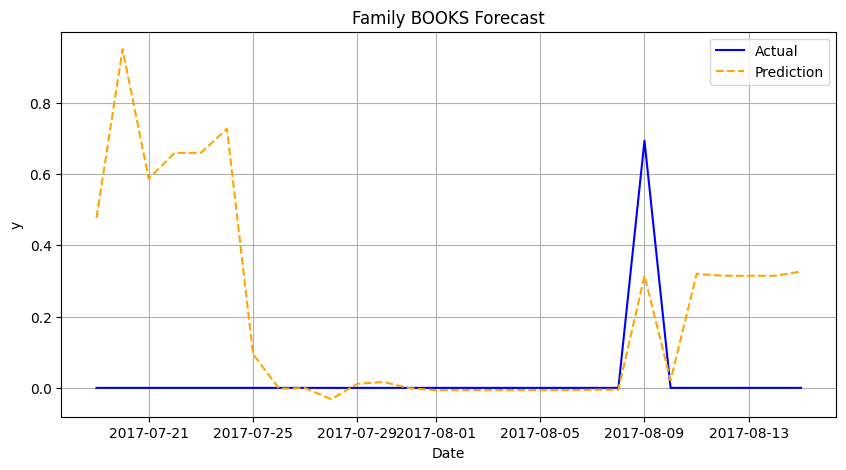

In [173]:
# Example: plot for one family
selected_family = family_list[i]
plot_forecast(
    pred_df=pred_df,
    date_col=cfg["data"]["date_col"],
    actual_col="y",
    pred_col="prediction",
    group_cols=['family'], #cfg["data"]["group_cols"],
    series_id={"family": selected_family},
    title=f"Family {selected_family} Forecast"
)
i +=1


In [ ]:
plot_train_test_forecast(train, test, pred,
                         date_col=cfg["data"]["date_col"],
                         target_col="sales",
                         pred_col="prediction",
                         group_cols=cfg["data"]["group_cols"],
                         series_id={"family": selected_family}, last_n_train=120)

i += 1

In [0]:
run_forecast(df, cfg=cfg)

In [0]:
agg_cols = ['family', 'store_nbr', 'state', 'city', 'type', 'cluster'] # there is one store per city and type and cluster so adding those feature is redundant
agg_cols = ['family', 'store_nbr'] # there is one store per city and type and cluster so adding those feature is redundant

# agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"dcoilwtico": "mean"}  # optional
)
print(df_agg.count())
df_agg.show(2)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1, 7, 14, 28],
    mas=[7, 28],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
df_feat.show(10)
print(df_feat.count())
# df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'dcoilwtico', 'lag_1', 'lag_2']).show(10)

In [0]:
from icecream import ic

d, a, f, s, m, e = (
    cfg["data"],
    cfg.get("aggregation", {}),
    cfg["features"],
    cfg["split"],
    cfg["model"],
    cfg["evaluation"],
)

df_agg = aggregate_to_granularity(
    df_raw,
    d["date_col"],
    d["target_col"],
    d["group_cols"],
    agg=a.get("target_agg", "sum"),
    extra_numeric_aggs=a.get("extra_numeric_aggs"),
)
ic()

bt = rolling_backtest(
    df_agg,
    d["date_col"],
    d["target_col"],
    d["group_cols"],
    feature_params={
        "lags": f["lags"],
        "mas": f["mas"],
        "add_time_signals": f["add_time_signals"],
        "freq": d.get("freq", "D"),
    },
    model_type=m["type"],
    model_params=m["params"],
    folds=e["backtest"]["folds"],
    fold_horizon=e["backtest"]["fold_horizon"],
    step=e["backtest"]["step"],
    mase_seasonality=e["mase_seasonality"],
)


In [0]:
bt.show()

In [0]:
# agg_cols = ['family', 'store_nbr']
agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"price": "mean", "promo_spend": "sum"}  # optional
)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1,2],
    mas=[1,2],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
print(df_feat.count())
df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'lag_1', 'lag_2']).show(10)
df_feat.show(10)

In [0]:
train, test = train_test_split(df=df_feat, date_col='date', group_cols=agg_cols, mode='horizon', test_horizon=28)
train.show(2)
test.show(2)

In [0]:
agg_cols = ['family', 'family']
# agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"price": "mean", "promo_spend": "sum"}  # optional
)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1,2],
    mas=[1,2],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
print(df_feat.count())
df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'lag_1', 'lag_2']).show(10)

In [0]:
dfx = build_features(df, "date", "sales", ["family", "store_nbr"], lags=[1, 2], mas=[1])
print(dfx.count())
dfx.sort(["family", "store_nbr", "date"]).select(['family', 'store_nbr', 'date', 'sales', 'lag_1', 'lag_2']).show(10)

In [0]:
dfx = build_features(df, "date", "sales", ["family"], lags=[1, 2], mas=[1])
print(dfx.count())
dfx.sort(["family", "store_nbr", "date"]).select(['family', 'store_nbr', 'date', 'sales', 'lag_1', 'lag_2']).show(10)

In [0]:
# Load config from YAML or dict
import yaml, json
cfg = yaml.safe_load(open("forecast_config.yaml"))

out = run_forecast(df_feat, cfg)

display(out["predictions"])         # per-group predictions on test window
# display(out["metrics_portfolio"])   # wMAPE, sMAPE, MASE overall
# display(out["metrics_by_series"])   # same metrics by series
# display(out["backtest"])            # rolling-origin backtest summary (if enabled)
